# Analysis of Parameter Estimation

In [120]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import tellurium as te  
import json
import os


### Load all data relevant for analysis

In [121]:
pth_model = te.loada('../LCT_model/LCT_OIE.ant')
non_pth_model = te.loada('../LCT_model/LCT_OIE.ant')

data = pd.read_csv('../datasets/OIE_data.csv')

# Define the directory containing the files
directory = '../Estimation/pth/'

# Initialize an empty list to store file names
file_list = []

# Iterate over files in the directory
for filename in os.listdir(directory):
    filepath = os.path.join(directory, filename)
    # Check if the path is a file (not a directory)
    if os.path.isfile(filepath):
        # Add the file path to the list
        file_list.append(filepath)
file_list = sorted(file_list)
newest_file_name = file_list[-1].split("/")[-1].split(".")[0]
estimation_run = newest_file_name                          

#estimation_run = "2024_02_07_15_51_1" # hill function estimation
#no hill function estimation, too high J_P_death but better R: "2023_12_20_17_13_1" 
#estimation Hkt_init: "2023_12_18_11_09_1"
#nice curves, estimated k_P_birth: 2023_12_14_14_50_1           
#Best cost function, but new steady state as k_P_birth higher: "2023_12_15_10_44_1"

fit_data_pth = pd.read_csv('../Estimation/pth.csv')
with open(f'../Estimation/pth/{estimation_run}.json', 'r') as f:
  pth_result = json.load(f)
            
fit_data_non_pth = pd.read_csv('../Estimation/non_pth.csv')
with open(f'../Estimation/non_pth/{estimation_run}.json', 'r') as f:
  non_pth_result = json.load(f)


In [122]:
species_selct = ['time', '[R]', '[iE]', '[E]', 'oiE', 'Hkt', 'Hb', 'LDH',
                 'parasitemia', 'RPI', 'J_P_aging', 'J_P_death', '[P]',"J_P_birth",
                 'J_oiE_death', 'k_E_death', 'k_P_birth'] + [f'[oiE_{i}]' for i in range(1, 13)]
pth_model.resetToOrigin()
for p in pth_result['update_parameters']:
    pth_model.setValue(p, pth_result['update_parameters'][p])
    
pre_t = pth_result['best_parameters']['pre_t']
pth_res = pth_model.simulate(-pre_t, 50, 200, selections=species_selct)
pth_res_df = pd.DataFrame(pth_res, columns=pth_res.colnames) 

non_pth_model.resetToOrigin()
for p in non_pth_result['update_parameters']:
    non_pth_model.setValue(p, non_pth_result['update_parameters'][p])

pre_t = non_pth_result['best_parameters']['pre_t']
#non_pth_model.events_medication_on = False
non_pth_res = non_pth_model.simulate(-pre_t, 100, 200, selections=species_selct)
non_pth_res_df = pd.DataFrame(non_pth_res, columns=non_pth_res.colnames) 


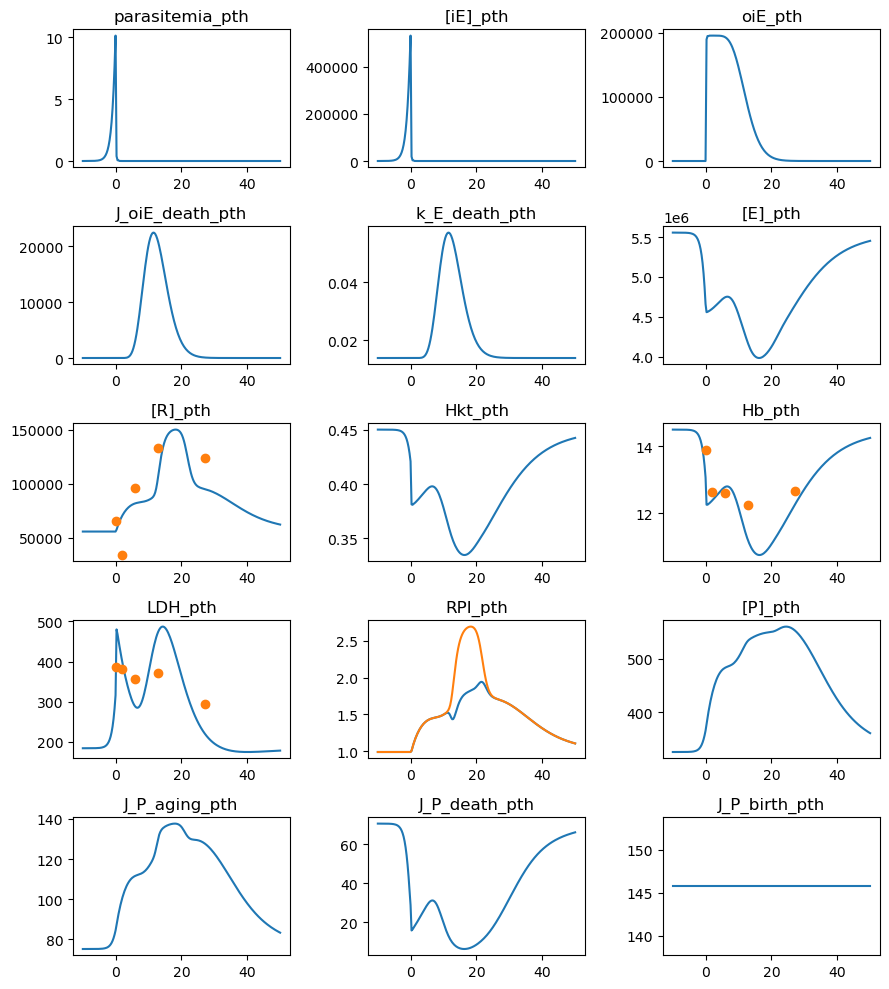

In [123]:
## plot results
observables = ['parasitemia', '[iE]', 'oiE', 'J_oiE_death', 'k_E_death',
               '[E]', '[R]', 'Hkt' ,'Hb', 'LDH','RPI','[P]', 'J_P_aging', 'J_P_death',"J_P_birth"]

n_cols = 3
n_rows = int(np.ceil(len(observables)/n_cols))  

fig, ax = plt.subplots(n_rows, n_cols, squeeze=True, figsize=(n_cols*3, n_rows*2))

for i, obs in enumerate(observables):
    row = i//n_cols
    col = i%n_cols
    #ax[row, col].plot(pth_res_df['time'], pth_res_df[obs], label='no BH')
    ax[row, col].plot(pth_res_df['time'], pth_res_df[obs])

    ax[row, col].set_title(obs+"_pth")
    #ax[row, col].legend()
ax[3,0].plot(fit_data_pth['Time'], fit_data_pth['LDH_mean'], 'o', label='data')
ax[2,2].plot(fit_data_pth['Time'], fit_data_pth['Hb_mean'], 'o', label='data')
ax[2,0].plot(fit_data_pth['Time'], fit_data_pth['[R]_mean'], 'o', label='data')
# maturation time = 1, assumption Hkt does go underneath 0.4, in model   
rpi_calc = (pth_res_df['[R]'] / (pth_res_df['[R]'] + pth_res_df['[E]']+pth_res_df['[iE]'] + pth_res_df['oiE'])) * pth_res_df['Hkt'] / (0.45*0.01)
ax[3, 1].plot(pth_res_df['time'], rpi_calc)

plt.tight_layout()  
plt.show()


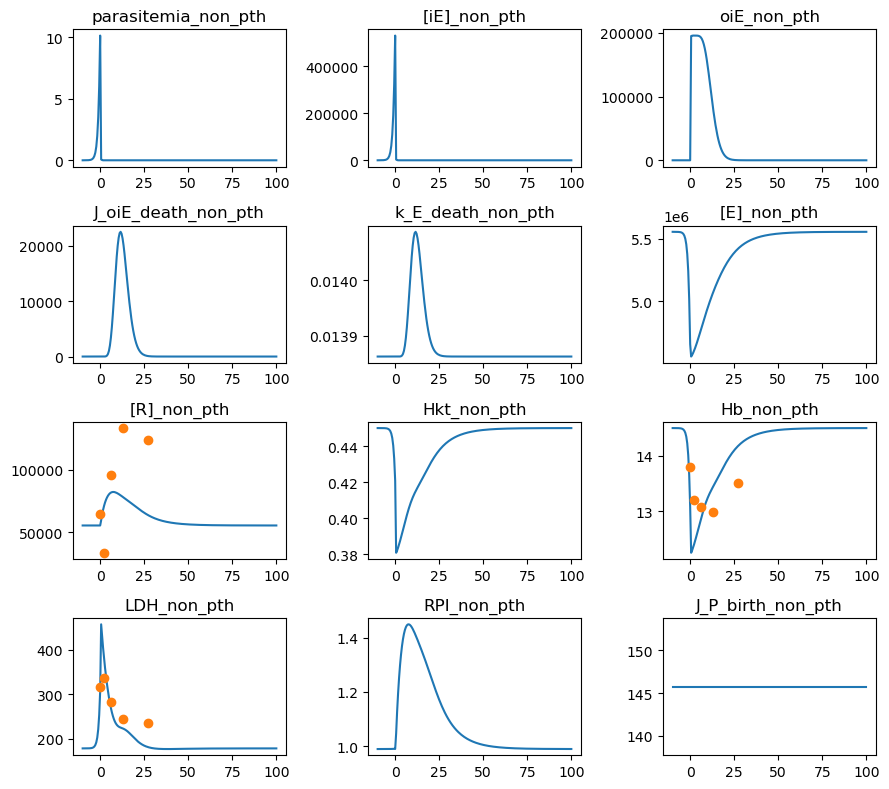

In [124]:
## plot results
observables = ['parasitemia', '[iE]', 'oiE', 'J_oiE_death', 'k_E_death','[E]', '[R]', 'Hkt' ,'Hb', 'LDH','RPI',"J_P_birth"]

n_cols = 3
n_rows = int(np.ceil(len(observables)/n_cols))  

fig, ax = plt.subplots(n_rows, n_cols, squeeze=True, figsize=(n_cols*3, n_rows*2))

for i, obs in enumerate(observables):
    row = i//n_cols
    col = i%n_cols
    #ax[row, col].plot(pth_res_df['time'], pth_res_df[obs], label='no BH')
    ax[row, col].plot(non_pth_res_df['time'], non_pth_res_df[obs])

    ax[row, col].set_title(obs+"_non_pth")
    #ax[row, col].legend()
ax[3,0].plot(fit_data_non_pth['Time'], fit_data_non_pth['LDH_mean'], 'o', label='data')
ax[2,2].plot(fit_data_non_pth['Time'], fit_data_non_pth['Hb_mean'], 'o', label='data')
ax[2,0].plot(fit_data_pth['Time'], fit_data_pth['[R]_mean'], 'o', label='data')

plt.tight_layout()  
plt.show()
